In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import numpy as np
import pandas as pd
from divexplorer_generalized.FP_Divergence import FP_Divergence

# Import data

In [4]:
dataset_name = "online_shoppers_intention"

In [30]:
from import_process_dataset import DATASET_DIR

def import_process_online_shoppers_intention(inputDir=DATASET_DIR):

    if os.path.isfile(os.path.join(DATASET_DIR, dataset_name+".csv")):

        df = pd.read_csv(os.path.join(DATASET_DIR, dataset_name+".csv"), sep=",")
    else:
        df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv", sep=",")

    class_map = {'P': True, 'N': False}
    df.rename(columns = {"Revenue": "class"}, inplace=True)
    
    df['Month'] = df['Month'].replace({'May': 5, 'Nov': 11, 'Mar': 3, 'Dec': 12, 'Oct': 10, 'Sep': 9, 'Aug': 8, 'Jul': 7, 'June': 6, 'Feb': 2})

    continuous_attributes = list(df.describe().columns)
    continuous_attributes.remove('SpecialDay')
    return df, class_map, continuous_attributes

In [31]:
df, class_map, continuous_attributes = import_process_online_shoppers_intention()

In [20]:
for c in continuous_attributes:
    cnt = df[c].value_counts()
    if len(cnt)<20:
        print(c, len(cnt), dict(cnt))
    else:
        print(c, len(cnt))

Administrative 27
Administrative_Duration 3335
Informational 17 {0: 9699, 1: 1041, 2: 728, 3: 380, 4: 222, 5: 99, 6: 78, 7: 36, 9: 15, 8: 14, 10: 7, 12: 5, 14: 2, 16: 1, 11: 1, 24: 1, 13: 1}
Informational_Duration 1258
ProductRelated 311
ProductRelated_Duration 9551
BounceRates 1872
ExitRates 4777
PageValues 2704
Month 10 {5: 3364, 11: 2998, 3: 1907, 12: 1727, 10: 549, 9: 448, 8: 433, 7: 432, 6: 288, 2: 184}
OperatingSystems 8 {2: 6601, 1: 2585, 3: 2555, 4: 478, 8: 79, 6: 19, 7: 7, 5: 6}
Browser 13 {2: 7961, 1: 2462, 4: 736, 5: 467, 6: 174, 10: 163, 8: 135, 3: 105, 13: 61, 7: 49, 12: 10, 11: 6, 9: 1}
Region 9 {1: 4780, 3: 2403, 4: 1182, 2: 1136, 6: 805, 7: 761, 9: 511, 8: 434, 5: 318}
TrafficType 20


In [12]:
for c in df.columns:
    if c not in continuous_attributes:
        cnt = df[c].value_counts()
        print(c, len(cnt), dict(cnt))

Month 10 {'May': 3364, 'Nov': 2998, 'Mar': 1907, 'Dec': 1727, 'Oct': 549, 'Sep': 448, 'Aug': 433, 'Jul': 432, 'June': 288, 'Feb': 184}
VisitorType 3 {'Returning_Visitor': 10551, 'New_Visitor': 1694, 'Other': 85}
Weekend 2 {False: 9462, True: 2868}
class 2 {False: 10422, True: 1908}


In [37]:
from import_process_dataset import train_classifier_kv

df_analyze = train_classifier_kv(df, encoding=True)

# Train and predict with RF classifier

In [38]:
from sklearn.metrics import accuracy_score

accuracy_score(df_analyze['class'], df_analyze['predicted'])

0.9005677210056772

# Tree divergence

In [39]:
true_class_name = "class"
pred_class_name = "predicted"
cols_c = [true_class_name, pred_class_name]

In [40]:
min_support_tree = 0.1

In [41]:
metric = "d_error"

In [42]:
type_criterion="divergence_criterion"

type_experiment = "one_at_time"

In [43]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

# ## Extract tree
generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analyze,
    type_splitting=type_experiment,
    min_support=min_support_tree,
    metric=metric,
    class_map=class_map,
    continuous_attributes=list(continuous_attributes),
    class_and_pred_names=cols_c,
    storeTree=True,
    type_criterion= type_criterion, #'divergence_criterion', #type_criterion,
#    minimal_gain = 0
)

In [44]:
tree_discr.printDiscretizationTrees(round_v =2, show_condition = True)

Administrative
 root s=1.00 --> d_error=0.00
         Administrative<=0 s=0.47 --> d_error=-0.06
         Administrative>0 s=0.53 --> d_error=0.05
                 Administrative<=5 s=0.38 --> d_error=0.03
                         Administrative<=3 s=0.27 --> d_error=0.02
                                 Administrative<=1 s=0.11 --> d_error=0.01
                                 Administrative>1 s=0.16 --> d_error=0.03
                         Administrative>3 s=0.11 --> d_error=0.04
                 Administrative>5 s=0.15 --> d_error=0.12

Administrative_Duration
 root s=1.00 --> d_error=0.00
         Administrative_Duration<=12.0 s=0.52 --> d_error=-0.05
         Administrative_Duration>12.0 s=0.48 --> d_error=0.06
                 Administrative_Duration<=132.05 s=0.30 --> d_error=0.04
                         Administrative_Duration<=46.61111111 s=0.11 --> d_error=0.05
                         Administrative_Duration>46.61111111 s=0.18 --> d_error=0.04
                 Administrati

# Extract patterns

In [45]:
out_support = {}
out_time = {}

In [47]:
min_sup_divergences = [0.1, 0.15, 0.2] #0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2
# 0.075

In [48]:
import time

## Base

In [49]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)

for min_sup_divergence in min_sup_divergences:
    s_time = time.time()
    FP_fm = extract_divergence_generalized(
        df_analyze,
        discretizations,
        generalization_dict,
        continuous_attributes,
        min_sup_divergence=min_sup_divergence,
        apply_generalization=False,
        true_class_name=true_class_name,
        predicted_class_name=pred_class_name,
        class_map=class_map,
        metrics_divergence = [metric],
        FPM_type="fpgrowth",
    )
    
    out_time.setdefault(min_sup_divergence, {})["base"] = time.time()-s_time
    
    most_divergent = max(FP_fm[metric])
    out_support.setdefault(min_sup_divergence, {})["base"] = most_divergent
    
    

## Generalized

In [50]:
from utils_extract_divergence_generalized import (
    extract_divergence_generalized,
)
import time



for min_sup_divergence in min_sup_divergences:
    s_time = time.time()
    FP_fm = extract_divergence_generalized(
        df_analyze,
        discretizations,
        generalization_dict,
        continuous_attributes,
        min_sup_divergence=min_sup_divergence,
        apply_generalization=True,
        true_class_name=true_class_name,
        predicted_class_name=pred_class_name,
        class_map=class_map,
        metrics_divergence = [metric],
        FPM_type="fpgrowth",
        save_in_progress = False
    )
    
    out_time.setdefault(min_sup_divergence, {})["generalized"] = time.time()-s_time
    
    most_divergent = max(FP_fm[metric])
    out_support.setdefault(min_sup_divergence, {})["generalized"] = most_divergent

1 10000
2 20000
3 30000
4 40000
5 50000
6 60000
7 70000
8 80000
9 90000
10 100000
11 110000
12 120000
13 130000
14 140000
15 150000
16 160000
17 170000
18 180000
19 190000
20 200000
1 10000
2 20000
3 30000
4 40000
1 10000


# Results

In [53]:
out_time

{0.1: {'base': 2.471522569656372, 'generalized': 47.19915413856506},
 0.15: {'base': 1.4236409664154053, 'generalized': 16.326154232025146},
 0.2: {'base': 0.6280920505523682, 'generalized': 7.7478039264678955}}

In [54]:
out_support

{0.1: {'base': 0.27595471790970194, 'generalized': 0.28579010264125826},
 0.15: {'base': 0.12103237745649276, 'generalized': 0.26084609359668365},
 0.2: {'base': 0.08359470575342842, 'generalized': 0.2192834610213389}}

# Plot results

In [55]:
import os

output_fig_dir = os.path.join(os.path.curdir, "output_figures", "figures", "output_performance")
from pathlib import Path

Path(output_fig_dir).mkdir(parents=True, exist_ok=True)

In [56]:
abbreviations = {"one_at_time":"indiv t.", \
                  "divergence_criterion":"g$\\Delta$", "entropy":"entr"}

In [57]:
def abbreviateValue(value, abbreviations={}):
    for k, v in abbreviations.items():
        if k in value:
            
            value = value.replace(k, v)
    #TODO
    if value[0:2] not in ["q_", "u_"]:
        value = value.replace("_", " ")
    return value
    
def abbreviate_dict_value(input_dict, abbreviations):
    
    conv ={}
    for k1, dict_i in input_dict.items():
        conv[k1] = { abbreviateValue(k, abbreviations): d for k, d in dict_i.items()}
    return conv

In [58]:
color_labels = {}
color_labels[abbreviateValue(f'entropy_base', abbreviations)]="#7fcc7f"
color_labels[abbreviateValue(f'divergence_criterion_base', abbreviations)]="#009900"

color_labels[abbreviateValue(f'entropy_generalized', abbreviations)]="mediumblue"
color_labels[abbreviateValue(f'divergence_criterion_generalized', abbreviations)]="orangered"

lines_style = {k:"-" for k in color_labels}
print(color_labels)
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"-." for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

{'entr base': '#7fcc7f', 'g$\\Delta$ base': '#009900', 'entr generalized': 'mediumblue', 'g$\\Delta$ generalized': 'orangered'}


## Plot time

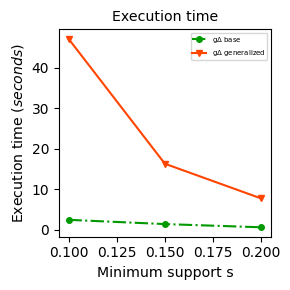

In [59]:
from utils_plot import plotDicts



info_plot = {}
for sup in sorted(out_time.keys()):
    for type_gen in out_time[sup]:
        type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}", abbreviations)
        if type_gen_str not in info_plot:
            info_plot[type_gen_str] = {}
        info_plot[type_gen_str][sup] = out_time[sup][type_gen]
        
        
size_fig = (3,3)


info_i = "time"

figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")




plotDicts(info_plot, marker=True, \
          title = 'Execution time', sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
          xlabel="Minimum support s",  ylabel="Execution time $(seconds)$", labelSize=10.2,\
         outside=False,  saveFig=True, nameFig = figure_name)

## Plot max

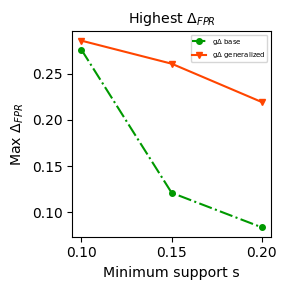

In [61]:
from utils_plot import plotDicts



info_plot = {}
for sup in sorted(out_support.keys()):
    for type_gen in out_support[sup]:
        type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}", abbreviations)
        if type_gen_str not in info_plot:
            info_plot[type_gen_str] = {}
        info_plot[type_gen_str][sup] = out_support[sup][type_gen]
        
        
size_fig = (3,3)


info_i = f"max_{metric}"

figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")




plotDicts(info_plot, marker=True, \
          title="Highest $\\Delta_{FPR}$" , sizeFig=size_fig,
                   linestyle=lines_style, color_labels=color_labels, \
          xlabel="Minimum support s",  ylabel="Max $\\Delta_{FPR}$", labelSize=10.2,\
         outside=False,  saveFig=True, nameFig = figure_name) #yscale="log",  

In [ ]:
df_analyze.shape[0]*0.01